# Text classification (multiclass)

Tutorial for beginners in text classification analysis using Python

Data: Consumer complaints received about financial products and services

Data source: Public dataset downloaded from https://catalog.data.gov/dataset/consumer-complaint-database on 2019, May 13.

These are real world complaints received about financial products and services. Each complaint has been labeled with a specific product; therefore, this is a supervised text classification problem. With the aim to classify future complaints based on its content, we used different machine learning algorithms can make more accurate predictions (i.e., classify the complaint in one of the product categories).

## Table of Content

- Goal
- Importing packages and loading data
- Exploratory Data Analysis (EDA) and Feature Engineering
- Text Preprocessing
- Multi-Classification models
  - Spliting the data: train and test
  - Models
- Comparison of model performance
- Model Evaluation
  - Precision, Recall, F1-score
  - Confusion Matrix
- Predictions

### Goal:
Classify consumer complaints into predefined categories.

Classification algorithms: Linear Support Vector Machine (LinearSVM), Random Forest, Multinomial Naive Bayes and Logistic Regression.

Note: Text classification is an example of supervised machine learning since we train the model with labelled data (complaints about and specific finance product is used for train a classifier.

### Importing packages and loading data

In [1]:
# Input data files are available in the "../input/" directory.
import os
print(os.listdir(r"C:\Users\XXXXXXX\XXXX"))

import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

['.ipynb_checkpoints', 'Capstone-Text classification (multiclass) - notebook.ipynb', 'Capstone-Text classification (multiclass).ipynb', 'rows.csv']


In [2]:
df = pd.read_csv("C:/Users/91988/Desktop/Springboard/Capstone-Text classification (multiclass)/rows.csv/rows.csv")
df.shape

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,5,6,11,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(1282355, 18)

We have more than 1 million instances (rows) and 18 features (columns).

#### Exploratory Data Analysis (EDA) and Feature Engineering

In [3]:
df.head(2).T # Columns are shown in rows for easy reading

,0,1
Date received,05/10/2019,05/10/2019
Product,Checking or savings account,Checking or savings account
Sub-product,Checking account,Other banking product or service
Issue,Managing an account,Managing an account
Sub-issue,Problem using a debit or ATM card,Deposits and withdrawals
Consumer complaint narrative,NaN,NaN
Company public response,NaN,NaN
Company,NAVY FEDERAL CREDIT UNION,BOEING EMPLOYEES CREDIT UNION
State,FL,WA
ZIP code,328XX,98204


The dataset contains features that are not necessary to solve our multi-classification problem. For this text classification problem, we are going to build another dataframe that contains ‘Product’ and ‘Consumer complaint narrative’ (renamed as 'Consumer_complaint').

In [4]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint'] 

df1.shape

(383564, 2)

In [5]:
# Percentage of complaints with text
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(df)*100),1)

29.9

From more than 1 million complaints, there are about 380,000 cases with text (~ 30% of the original dataset is not null). This is still a good number to work with. Now let's have a look at the categories we want to classify each complaint.

In [6]:
pd.DataFrame(df.Product.unique()).values

array([['Checking or savings account'],
       ['Debt collection'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Mortgage'],
       ['Student loan'],
       ['Vehicle loan or lease'],
       ['Credit card or prepaid card'],
       ['Payday loan, title loan, or personal loan'],
       ['Money transfer, virtual currency, or money service'],
       ['Credit reporting'],
       ['Credit card'],
       ['Bank account or service'],
       ['Consumer Loan'],
       ['Prepaid card'],
       ['Other financial service'],
       ['Payday loan'],
       ['Money transfers'],
       ['Virtual currency']], dtype=object)

There are 18 different classes or categories (target). However; it is observed that some classes are contained in others. For instance, ‘Credit card’ and ‘Prepaid card’ are contained in ‘Credit card or prepaid card’ category. Now, imagine there is a new complaint about Credit card and we want to classify it. The algorithm can either classify this complaint as 'Credit card' or 'Credit card or prepaid' and it would be correct. Nevertheless, this would affect model performance. In order to avoid this problem, the names of some categories were renamed.

In [7]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [8]:
# Renaming categories
df2.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [9]:
pd.DataFrame(df2.Product.unique())

,0
0,"Credit reporting, repair, or other"
1,Debt collection
2,Consumer Loan
3,Credit card or prepaid card
4,Mortgage
5,Vehicle loan or lease
6,Student loan
7,"Payday loan, title loan, or personal loan"
8,Checking or savings account
9,Bank account or service


The number of classes were reduced from 18 to 13.

Now we need to represent each class as a number, so as our predictive model can better understand the different categories.

In [10]:
# Create a new column 'category_id' with encoded categories 
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
310399,"Credit reporting, repair, or other",Bayview completely ignored laws and is reporti...,0
186155,"Credit reporting, repair, or other",inaccurate information no knowledge of account...,0
651135,Debt collection,On XXXX/XXXX/2016 I received a notice from Con...,1
515233,Consumer Loan,I have a loan with Kia Motor Finance. I rece...,2
641112,Credit card or prepaid card,I have a XXXX BIG card and made my payment whe...,3


The bar chart below shows the number of complaints per category. It can be observed that The bar chart below shows the number of complaints per category. It can be observed that most of customer complaints are due to:

- credit reporting, credit repair
- debt collection
- mortgage

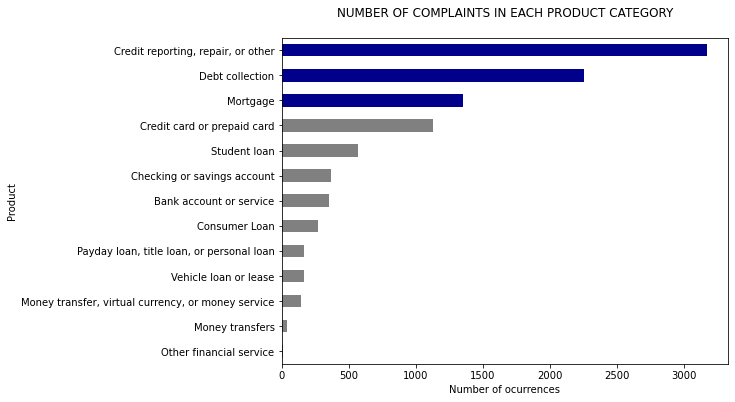

In [11]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

#### Text Preprocessing
The text needs to be transformed to vectors so as the algorithms will be able make predictions. In this case it will be used the Term Frequency – Inverse Document Frequency (TFIDF) weight to evaluate how important a word is to a document in a collection of documents.

After removing punctuation and lower casing the words, importance of a word is determined in terms of its frequency.

“Term Frequency – Inverse Document Frequency
TF-IDF is the product of the TF and IDF scores of the term.

TF-IDF=TFIDF
 


Term Frequency : This summarizes how often a given word appears within a document.

TF=Number of times the term appears in the docTotal number of words in the doc
 


Inverse Document Frequency: This downscales words that appear a lot across documents. A term has a high IDF score if it appears in a few documents. Conversely, if the term is very common among documents (i.e., “the”, “a”, “is”), the term would have a low IDF score.

IDF=ln(Number of docsNumber docs the term appears in)
 


TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents. The higher the TFIDF score, the rarer the term is. For instance, in a Mortgage complaint the word mortgage would be mentioned fairly often. However, if we look at other complaints, mortgage probably would not show up in many of them. We can infer that mortgage is most probably an important word in Mortgage complaints as compared to the other products. Therefore, mortgage would have a high TF-IDF score for Mortgage complaints.

TfidfVectorizer class can be initialized with the following parameters:
- <b>min_df</b>: remove the words from the vocabulary which have occurred in less than ‘min_df’ number of files.
- <b>max_df</b>: remove the words from the vocabulary which have occurred in more than _‘maxdf’ * total number of files in corpus.
- <b>sublinear_tf</b> : set to True to scale the term frequency in logarithmic scale.
- <b>stop_words</b>: remove the predefined stop words in 'english'.
- <b>use_idf</b>: weight factor must use inverse document frequency.
- <b>ngram_range</b>: (1, 2) to indicate that unigrams and bigrams will be considered.


In [12]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 27507 features (TF-IDF score of unigrams and bigrams)


In [13]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Bank account or service:
  * Most Correlated Unigrams are: overdraft, bank, scottrade
  * Most Correlated Bigrams are: citigold checking, debit card, checking account

==> Checking or savings account:
  * Most Correlated Unigrams are: checking, branch, overdraft
  * Most Correlated Bigrams are: 00 bonus, overdraft fees, checking account

==> Consumer Loan:
  * Most Correlated Unigrams are: dealership, vehicle, car
  * Most Correlated Bigrams are: car loan, vehicle loan, regional acceptance

==> Credit card or prepaid card:
  * Most Correlated Unigrams are: express, citi, card
  * Most Correlated Bigrams are: balance transfer, american express, credit card

==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: report, experian, equifax
  * Most Correlated Bigrams are: credit file, equifax xxxx, credit report

==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: debt collector, collect debt, collection 

##### Multi-Classification models

The classification models evaluated are:

- Random Forest
- Linear Support Vector Machine
- Multinomial Naive Bayes
- Logistic Regression.

##### Spliting the data into train and test sets
The original data was divided into features (X) and target (y), which were then splitted into train (75%) and test (25%) sets. Thus, the algorithms would be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

In [14]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

#### Models

In [15]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

##### Comparison of model performance
The best mean acuracy was obtained with LinearSVC.

In [16]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.7791,0.005561
LogisticRegression,0.7641,0.009839
MultinomialNB,0.6475,0.004596
RandomForestClassifier,0.3949,0.006665


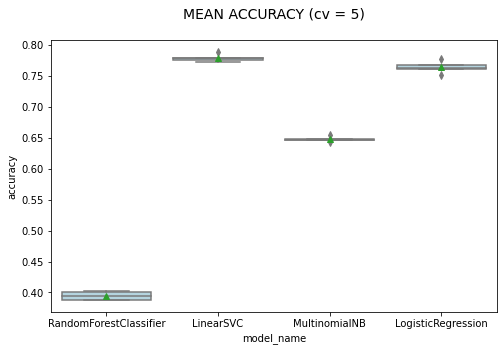

In [17]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

##### Model Evaluation

In [18]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

##### Precision, Recall, F1-score

In [19]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df2['Product'].unique()))

				CLASSIFICATIION METRICS

                                                    precision    recall  f1-score   support

                Credit reporting, repair, or other       0.81      0.88      0.84       783
                                   Debt collection       0.76      0.80      0.78       588
                                     Consumer Loan       0.52      0.22      0.31        73
                       Credit card or prepaid card       0.73      0.82      0.77       253
                                          Mortgage       0.87      0.92      0.90       340
                             Vehicle loan or lease       0.43      0.14      0.21        43
                                      Student loan       0.85      0.85      0.85       155
         Payday loan, title loan, or personal loan       0.50      0.17      0.26        40
                       Checking or savings account       0.61      0.60      0.61        85
                           Bank account or service

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


It is possible to observe that the classes with more support (number of occurrences) tend to have a better f1-cscore. This is because the algorithm was trained with more data.

The classes that can be classified with more precision are ‘Mortgage’, ‘Credit reporting, repair, or other’, and ‘Student loan’.

##### Confusion Matrix
A Confusion Matrix is a table which rows represent the actual class and columns represents the predicted class.

If we had a perfect model that always classifies correctly a new complaint, then the confusion matrix would have values in the diagonal only (where predicted label = actual label)

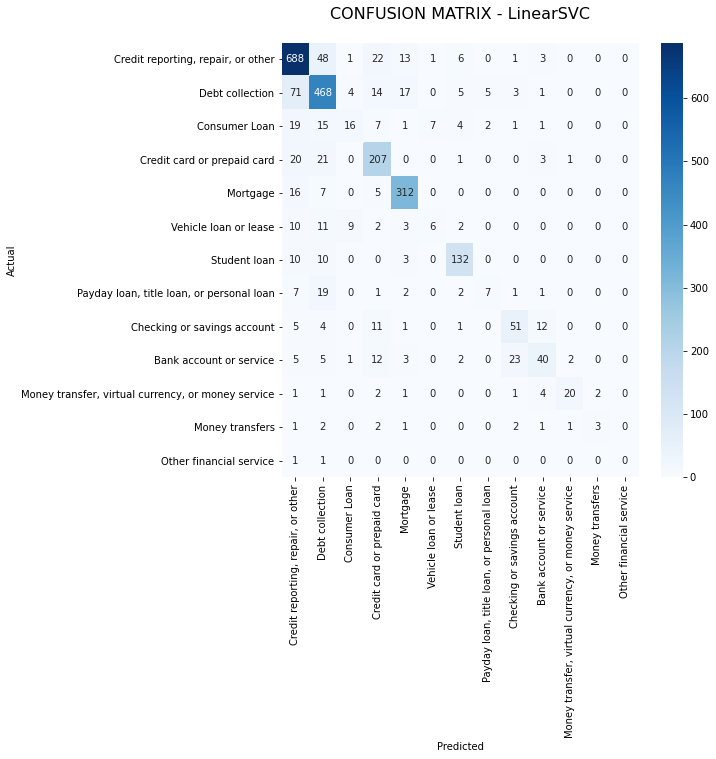

In [20]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In general, the confusion matrix looks good (clear diagonal that represents correct classifications). Nevertheless, there are cases were the complaint was classified in a wrong class.

##### Misclassified complaints
Let’s have a look at the cases that were wrongly classified.

In [21]:
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 20:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
        display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 
                                                                'Consumer_complaint']])
        print('')

,Product,Consumer_complaint
359686,"Credit reporting, repair, or other","On XXXX XXXX, XXXX I sent letters to XXXX, Exp..."
622954,"Credit reporting, repair, or other",There are XXXX other addresses not associated ...
466485,"Credit reporting, repair, or other",I spoke to Experian on XXXX2017 about my conce...
61107,"Credit reporting, repair, or other",I recently filed a dispute with Experian becau...
238211,"Credit reporting, repair, or other",THIS IS ON MY EXPERIAN ACCOUNT ( 1 ) XXXX XXXX...
...,...,...
683039,"Credit reporting, repair, or other",Transunion had a glitch in their system when I...
620327,"Credit reporting, repair, or other",Noticed some fraudulent stuff on my credit rep...
801587,"Credit reporting, repair, or other",Regarding XXXX Credit Card accounts with XXXX....
517600,"Credit reporting, repair, or other",My accounts with : XXXX XXXX XXXX # XXX...



'Debt collection' predicted as 'Credit reporting, repair, or other' : 71 examples.


,Product,Consumer_complaint
483075,Debt collection,This agency has three collections listed which...
111807,Debt collection,I am writing to dispute the inaccurate data be...
376788,Debt collection,check n ' Go payday loan made me a loan and th...
570764,Debt collection,THIS AMT OWED {$8800.00} WAS TO BE PAID UNDER ...
88089,Debt collection,I am submitting this complaint for an account ...
...,...,...
155139,Debt collection,"Between XX/XX/XXXX and XX/XX/XXXX, this accoun..."
360018,Debt collection,"On XXXX XXXX, 2017 XXXX opened up an account f..."
165296,Debt collection,I have tried disputing with the bureau on seve...
159609,Debt collection,This is a complaint against National Credit Sy...


,Product,Consumer_complaint
560852,Consumer Loan,Payments are due the XXXX of the month ; payme...
804031,Consumer Loan,XXXX been told multiply times not to call my j...
807073,Consumer Loan,they call me at work text me call all my refre...
811593,Consumer Loan,On XXXX/XXXX/14 my son bought a car financed t...
530293,Consumer Loan,This is not a LOAN or CREDIT DEBT but a CLAIM ...
912145,Consumer Loan,I have a car loan that I have paid over $ 8k b...
602631,Consumer Loan,"I leased a car from Capital One 2 years ago, I..."
745856,Consumer Loan,My name is XXXX XXXX XXXX date of birth XXXX/X...
765976,Consumer Loan,XXXX/XXXX/XXXX GM FINANCIAL ACC # XXXX Late Da...
650483,Consumer Loan,"On XXXX XXXX, 2016, I contacted XXXX XXXX XXXX..."



'Credit card or prepaid card' predicted as 'Credit reporting, repair, or other' : 20 examples.


,Product,Consumer_complaint
399397,Credit card or prepaid card,"On XXXX XXXX, XXXX I submitted correspondence ..."
752303,Credit card or prepaid card,I purchased a room size air conditioner from X...
544109,Credit card or prepaid card,To Whom May Concern : Early Spring XX/XX/XXXX ...
723669,Credit card or prepaid card,The Sychrony issued excessive credit to me thr...
202661,Credit card or prepaid card,I reviewed my credit report and saw an account...
891797,Credit card or prepaid card,I have a SYNCB/WALMART DUAL CARD. Unbeknownst ...
280866,Credit card or prepaid card,XX/XX/2017 Monthly payment XXXX dollars. I rea...
350390,Credit card or prepaid card,I received a letter from XXXX On XXXX XXXX 201...
413596,Credit card or prepaid card,"XXXX investigated the following listing, XXXX ..."
725609,Credit card or prepaid card,Seventh Ave has charged off an account and con...


,Product,Consumer_complaint
612877,Mortgage,I was part of a XXXX.settlement : Consent Orde...
304009,Mortgage,XXXX XXXX XXXX XXXX bought my loan from XXXX X...
886791,Mortgage,On XX/XX/XXXX we sent a FAX to our lender requ...
902377,Mortgage,"Talk with bank of america, why my monthly paym..."
603483,Mortgage,"XXXX XXXX, I sold my home and paid Astoria Ban..."
389547,Mortgage,Information incorrect well 's fargo. I had to ...
359267,Mortgage,FRAUD. Selene Finance is not a registered part...
873449,Mortgage,"I have a "" Home Equity Line Of Credit '' with ..."
652223,Mortgage,I have a Bank of American Mortgage Loan which ...
895004,Mortgage,I put my home in a bankruptcy in XX/XX/XXXX. T...


,Product,Consumer_complaint
190621,Vehicle loan or lease,TOYOTA MTR # Multiple lates retro reported whi...
73910,Vehicle loan or lease,"During XXXX of 2017, my wife scheduled but fai..."
235222,Vehicle loan or lease,American Honda Finance account number is not f...
472882,Vehicle loan or lease,I contacted Chase Auto Finance since my report...
170110,Vehicle loan or lease,I am about to go the 30 days late on my loan a...
53709,Vehicle loan or lease,I am continuing to have problems with GM Finan...
190357,Vehicle loan or lease,"I was in a XXXX XXXX in XX/XX/2017, which resu..."
294599,Vehicle loan or lease,"XXXX XXXX XXXX XXXX XXXX XXXX XXXX, CA XXXX ..."
164483,Vehicle loan or lease,XXXX XXXX XXXX {$9700.00} Opened XX/XX/XXXX Cl...
169184,Vehicle loan or lease,I leased a new XXXX through XXXX XXXX. I have ...


,Product,Consumer_complaint
62203,Student loan,XXXX XXXX reported to the IRS on XXXX for XXXX...
277682,Student loan,MY LOANS WITH XXXX WERE APPARENTLY TRANSFERRED...
598982,Student loan,"For the second consecutive month, Sallie Mae h..."
48628,Student loan,I am requesting that complaint XXXX be reopene...
310634,Student loan,Navient has reported negative information to m...
391854,Student loan,We are filing a lawsuit in the amount of XXXX ...
626423,Student loan,Navient keeps reporting late when i have filed...
164586,Student loan,I paid in full the amount of {$4600.00} to XXX...
897195,Student loan,I had applied for a student loan in the past b...
227798,Student loan,I made a lump sum payment to be spread equally...


,Product,Consumer_complaint
68206,"Payday loan, title loan, or personal loan",I took out a title loan with Eagle Financial i...
494780,"Payday loan, title loan, or personal loan","From XXXX XXXX XXXX , I filled out the ..."
606377,"Payday loan, title loan, or personal loan",Credit Shop said my interest rate was 32.25 %....
316237,"Payday loan, title loan, or personal loan",they posted on my credit score saying that i o...
396401,"Payday loan, title loan, or personal loan","Hello, On XXXX/XXXX/XXXX, I requested a free q..."
177198,"Payday loan, title loan, or personal loan",Springleaf changed it's name to OneMain that's...
128348,"Payday loan, title loan, or personal loan",I apparently signed a document authorizing you...


,Product,Consumer_complaint
478092,Checking or savings account,This is in reference to a dispute I filed in X...
512072,Checking or savings account,I 've been reported to XXXX because of an ac...
475653,Checking or savings account,My balance is n't updating in a timely manner
87079,Checking or savings account,I have a 2 fold issue with US Bank I have had ...
188477,Checking or savings account,We sent the following email to the Flagstar Cl...


,Product,Consumer_complaint
633337,Bank account or service,Citibank Checking account balance falls negati...
675261,Bank account or service,The company said they mailed forms to me a pos...
524156,Bank account or service,My XXXX report showed that there was a hard in...
866221,Bank account or service,"I have sent numerous letters, police reports a..."
803030,Bank account or service,Bank of America continues to deny me the abili...


,Product,Consumer_complaint
133191,"Money transfer, virtual currency, or money ser...","XX/XX/2018, i depostited {$1000.00} and they w..."


,Product,Consumer_complaint
597648,Money transfers,PayPal has failed to comply with the Fair Cred...


,Product,Consumer_complaint
533913,Other financial service,Lexington Law advertised that they could help ...



'Credit reporting, repair, or other' predicted as 'Debt collection' : 48 examples.


,Product,Consumer_complaint
167717,"Credit reporting, repair, or other",When my vehicle was repossessed in XX/XX/2017 ...
131925,"Credit reporting, repair, or other",I submitted a dispute online on a debt with XX...
675868,"Credit reporting, repair, or other",My name is XXXX XXXX. Your collection agency i...
370575,"Credit reporting, repair, or other",Credit reporting agency incorrectly keeps repo...
863037,"Credit reporting, repair, or other",This medical bill was paid to another collecto...
597294,"Credit reporting, repair, or other","I received a call, and my oldest daughter got ..."
301509,"Credit reporting, repair, or other",While attempting to get approval for a loan to...
404336,"Credit reporting, repair, or other",On XX/XX/XXXX I sent a letter to Wakefield & A...
310415,"Credit reporting, repair, or other","Portfolio Recov Assoc, Promise to remove the c..."
347164,"Credit reporting, repair, or other",XXXX Inquired because someone is trying to use...


,Product,Consumer_complaint
91165,Debt collection,I financed a XXXX XXXX XXXX XXXX XXXX for my ...
876258,Debt collection,I opened a small loan with this company who ta...
189306,Debt collection,I received a document from the Law Office of X...
781435,Debt collection,I have submitted XXXX complaints to the FTC re...
357034,Debt collection,I have been doing my due diligence to pay off ...
...,...,...
908248,Debt collection,Glenn Associates representative contacted me a...
189327,Debt collection,"XX/XX/18, received a collection notice from IC..."
741630,Debt collection,Harvard Collection Services ( possible owner X...
265480,Debt collection,I have been receiving calls from XXXX for a we...


,Product,Consumer_complaint
693090,Consumer Loan,regional acceptance is in violation of disclos...
659194,Consumer Loan,A copy of the letter sent to Lexus Financial i...
750468,Consumer Loan,Me and my wife have a auto loan through Consum...
650232,Consumer Loan,I am having financial difficulty and trying to...
548915,Consumer Loan,"After leasing a vehicle from Toyota, I traded ..."
591796,Consumer Loan,"I took out a personal loan with Avant, first o..."
656280,Consumer Loan,Today 1st Franklin came to my place of employm...
847723,Consumer Loan,"Today, XXXX I received an automatic dialer cal..."
757917,Consumer Loan,Harley Davidson is calling the office for debt...
749698,Consumer Loan,"Ally Financial calls on an auto dial system, w..."



'Credit card or prepaid card' predicted as 'Debt collection' : 21 examples.


,Product,Consumer_complaint
427835,Credit card or prepaid card,XXXX would not honor an offer to credit {$50.0...
468331,Credit card or prepaid card,hi I 'm on payment program with American expre...
36821,Credit card or prepaid card,"I am corresponding about my XXXX XXXX XXXX, wh..."
681770,Credit card or prepaid card,I sent the following message to Capital One on...
859065,Credit card or prepaid card,I had several attempts to get information abou...
504540,Credit card or prepaid card,This is in regards to BOTH a Total Visa acco...
872562,Credit card or prepaid card,I used a debt relief agency to pay my debts ( ...
609682,Credit card or prepaid card,I have a letter stating from American Express ...
907179,Credit card or prepaid card,I keep getting a robo call ( XXXX ) threatenin...
517845,Credit card or prepaid card,Bank of America is refusing to produce proof o...


,Product,Consumer_complaint
198004,Mortgage,I have never been given appointments or schedu...
815781,Mortgage,"On XXXX XXXX, XXXX wife and I received a lette..."
760240,Mortgage,I financed a mobilehome approximately in XXXX....
210517,Mortgage,ditech said i owe back payments talk to a lady...
301344,Mortgage,This is not a new complaint. I noticed that I ...
881674,Mortgage,In 2009 I went though a divorce in XXXX. Wells...
773445,Mortgage,Residential Credit Solutions wants me to pay {...


,Product,Consumer_complaint
48584,Vehicle loan or lease,My daughter and her boyfriend got an auto loan...
451321,Vehicle loan or lease,Lost job couldnt afford payments Company picke...
398403,Vehicle loan or lease,"TOYOTA FINANCIAL, creditor, auto loan account ..."
363521,Vehicle loan or lease,"on XX/XX/XXXX, Ally called my mom looking for ..."
411449,Vehicle loan or lease,I have attempted on numerous occasions to spea...
342273,Vehicle loan or lease,It started when my Employment Authorization Ca...
53867,Vehicle loan or lease,XX/XX/XXXX through XX/XX/2019 XXXX XXXX XXXX h...
138857,Vehicle loan or lease,XXXX XXXX XX/XX/XXXX To whom it may concern : ...
97507,Vehicle loan or lease,I spoke with and Representative on XX/XX/XXXX ...
418435,Vehicle loan or lease,"Back in XXXX, I let Capital One know that i ha..."


,Product,Consumer_complaint
485579,Student loan,I can not pay my loans the day they are due du...
642749,Student loan,I received a call from Navient requesting paym...
912425,Student loan,XXXX XXXX XXXX calls me and my cosigner multip...
573257,Student loan,"I had a loan with XXXX XXXX, that was paid off..."
454359,Student loan,In XX/XX/XXXX I was contacted by phone from XX...
614835,Student loan,I 'm being harassed by an unknown department o...
323740,Student loan,I saw on the internet that there are programs ...
693023,Student loan,On XXXX/XXXX/16 I received a letter from the c...
301198,Student loan,I am being overcharged for interest
515505,Student loan,My Federal Tax Refund w as recently garnished...


,Product,Consumer_complaint
872180,"Payday loan, title loan, or personal loan",I took out a loan with Westen Sky and it was i...
491967,"Payday loan, title loan, or personal loan",I am having trouble making the payments I borr...
539664,"Payday loan, title loan, or personal loan",Received a phone call from XXXX threatening ph...
643353,"Payday loan, title loan, or personal loan",I 'm in chapter XXXX bk since XX/XX/XXXX. Payd...
561584,"Payday loan, title loan, or personal loan",The opened date for this alleged debt with Ad ...
434023,"Payday loan, title loan, or personal loan",1 ) I extended/ renewed my pawn agreement with...
124961,"Payday loan, title loan, or personal loan",Company keeps calling my place of employment a...
324882,"Payday loan, title loan, or personal loan",XXXX/XXXX/2018 I attempted to use my personal ...
457311,"Payday loan, title loan, or personal loan",I received a phone call from Intgrated Recover...
292125,"Payday loan, title loan, or personal loan","I had a loan due XX/XX/2018, had told them i w..."


,Product,Consumer_complaint
295834,Checking or savings account,id theft happen to my account cra violation in...
500472,Checking or savings account,I have been a US Ba nk costumer for more than...
476686,Checking or savings account,I got paid this passed Friday XX/XX/17 and I '...
366073,Checking or savings account,UBS disbursed a check to me from my deposit ac...


,Product,Consumer_complaint
563920,Bank account or service,I set up recurring bill pay with Citibank thro...
753327,Bank account or service,My brother and sister and I had schedule to me...
670673,Bank account or service,Comerica Bank ( XXXX Bank ) Embezzlement consp...
678994,Bank account or service,I had two different answers from two associate...
602854,Bank account or service,I Open a New Account With Keybank XX/XX/2016. ...


,Product,Consumer_complaint
349299,"Money transfer, virtual currency, or money ser...",I have made the following withdrawals from my ...


,Product,Consumer_complaint
655344,Money transfers,I bought a XXXX from a woman in XXXX for XXXX....
865793,Money transfers,My son found a car on XXXX and contacted a lad...


,Product,Consumer_complaint
836319,Other financial service,"To Whom It May Concern, This complaints is aga..."


,Product,Consumer_complaint
276637,"Credit reporting, repair, or other",In late spring XX/XX/XXXX I got behind on my c...


,Product,Consumer_complaint
818161,Debt collection,I have filed for Chapter XXXX and was granted ...
382574,Debt collection,Let me preference this complaint with that I w...
303572,Debt collection,I voluntarily gave the car back because they s...
258705,Debt collection,I purchased a vehicle from XXXX and was financ...


,Product,Consumer_complaint
674090,Consumer Loan,I bought a XXXX Buick Lacrosse CX from Drive T...
562682,Consumer Loan,I am unable to get a duplicate title for my ve...
710103,Consumer Loan,I received a vehicle which was a lemon. I was ...
847092,Consumer Loan,There was an auto loan where the payments got ...
700357,Consumer Loan,I purchase a vehicle from motorama auto dealer...
621340,Consumer Loan,TD Bank is refusing to let me continue making ...
882113,Consumer Loan,I am XXXX of the victims of XXXX minority borr...
864687,Consumer Loan,I purchased a vehicle in 2010 for {$12000.00} ...
526843,Consumer Loan,I Get a title load i dint reliced they give me...
825569,Consumer Loan,I was given an auto loan through Santander Fin...


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint
331793,Vehicle loan or lease,"Purchased a boat trailer ( XXXX # XXXX ), titl..."
512114,Vehicle loan or lease,I gave XXXX cash and then I traded in my car...
486332,Vehicle loan or lease,This complaint is about US Banks end of lease ...
271709,Vehicle loan or lease,"On XX/XX/XXXX, I entered a lease on a XXXX XXX..."
184581,Vehicle loan or lease,I have a auto loan with Wells Fargo dealer ser...
156949,Vehicle loan or lease,XXXX XXXX XXXX in XXXX tricked me into purchas...
441646,Vehicle loan or lease,I got a first time Auto Loan through XXXX XXXX...
402146,Vehicle loan or lease,My complaint is with Bank of America XXXX XXXX...
461371,Vehicle loan or lease,I Leased an XXXX XXXX in XXXX and as...


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint
539935,Bank account or service,I bought a vehicle and got an auto loan throug...


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint



'Credit reporting, repair, or other' predicted as 'Credit card or prepaid card' : 22 examples.


,Product,Consumer_complaint
184965,"Credit reporting, repair, or other",XXXX is a company of XXXX and XXXX XXXX up my...
846410,"Credit reporting, repair, or other",There is incorrect credit card showing up on m...
192020,"Credit reporting, repair, or other",I went to the Capital One web site to apply fo...
265650,"Credit reporting, repair, or other",XXXX XXXX XXXX reported my account as charged ...
301997,"Credit reporting, repair, or other","XXXX Barclay , XXXX and XXXX are not updating ..."
473355,"Credit reporting, repair, or other",Company : USAA Summary of events : About XXXX ...
257154,"Credit reporting, repair, or other",I had an automatic payment of {$50.00} schedul...
168845,"Credit reporting, repair, or other",It percieved XXXX and other credit reporting a...
421206,"Credit reporting, repair, or other",Unable to get by bots or reach by telephone. C...
49300,"Credit reporting, repair, or other",In XX/XX/XXXX I needed a credit card to use to...


,Product,Consumer_complaint
324655,Debt collection,I have filed a previous report with CFPB due t...
284388,Debt collection,I was extended a credit account by Citibank to...
208940,Debt collection,The company billed a late fee on my account af...
792886,Debt collection,"I have a charge-off on my credit from "" MONTER..."
219372,Debt collection,My wife is an authorized user on my XXXX XXXX ...
883993,Debt collection,Received threatening letters so i called to cl...
261048,Debt collection,There was a debt of {$4900.00} from Citibank-B...
246570,Debt collection,As per telephone advice provided today by XXXX...
776072,Debt collection,"Hunt & Henriques, Attorneys at Law are debt co..."
785390,Debt collection,I paid on XXXX/XXXX/2015 to Focus Receivables ...


,Product,Consumer_complaint
756779,Consumer Loan,XX/XX/XXXX I opened a Home Depot/Citi Financia...
565438,Consumer Loan,"I asked for a month extension, something I hav..."
832484,Consumer Loan,"I went to XXXX in XXXX TX, in XXXX XXXX 2015 ;..."
687769,Consumer Loan,I have had several auto loans with Bank of Ame...
742439,Consumer Loan,I purchased a bed from XXXX XXXX ( financed th...
578209,Consumer Loan,On XX/XX/XXXX I applied for a loan on the XXXX...
538801,Consumer Loan,"I purchased appliances from XXXX in XXXX, Cali..."


,Product,Consumer_complaint
672012,Credit card or prepaid card,I was shocked when I reviewed my credit report...
340523,Credit card or prepaid card,"On XX/XX/XXXXXXXX, I attempted to make a withd..."
332957,Credit card or prepaid card,.I have a credit card with XXXX XXXX which is ...
719792,Credit card or prepaid card,I paid off my card balance in XXXX 2016. Appar...
699871,Credit card or prepaid card,I am a long time customer of Chase bank in goo...
...,...,...
233572,Credit card or prepaid card,I had 2 checks for {$1600.00} sent to Capital ...
707111,Credit card or prepaid card,XXXX/XXXX/XXXX made a purchase for {$2500.00} ...
266865,Credit card or prepaid card,I have been a Capital One customer for four ye...
598670,Credit card or prepaid card,I have contacted Chase multiple times about a ...


,Product,Consumer_complaint
621046,Mortgage,On XXXX XXXX 2016 Bank of America accepted a l...
867590,Mortgage,Greentree increased my electronic payment by {...
757416,Mortgage,If you make your payment on line and it is the...
836806,Mortgage,I am very dissatisfied with the results of my ...
643954,Mortgage,Homebridge contacted me about a missing paymen...


,Product,Consumer_complaint
362501,Vehicle loan or lease,I was shocked when I received my credit report...
490244,Vehicle loan or lease,My Auto Lease payment was due on X/XX/2017...


,Product,Consumer_complaint


,Product,Consumer_complaint
406255,"Payday loan, title loan, or personal loan",I bought a mattress with a 0 % APR over 3 year...


,Product,Consumer_complaint
180021,Checking or savings account,"On XX/XX/XXXX, I was doing my budget for the m..."
115516,Checking or savings account,"XXXX XXXX, a division of Comerica Bank, has al..."
232461,Checking or savings account,Wells Fargo is holding me accountable for a pu...
64358,Checking or savings account,I opened a Citi Priority account on XX/XX/XXXX...
402008,Checking or savings account,last year I opened a checking account with Cha...
237121,Checking or savings account,Capitol one is blocking me from enabling exter...
474335,Checking or savings account,BANK OF AMERICA IS A MUTHER XXXX CRIMINAL!!! T...
140531,Checking or savings account,Citi Locked my account XX/XX/XXXX for claiming...
108554,Checking or savings account,I opened my account on XX/XX/2018 online. On X...
283013,Checking or savings account,Bank of America has continued to take {$270.00...


,Product,Consumer_complaint
863457,Bank account or service,Someone hijacked my VA Pension check by orderi...
641104,Bank account or service,I recently looked at my Wells Fargo credit car...
577432,Bank account or service,I received a 0 % APR offer for 15 months on ba...
833382,Bank account or service,I recently went to get an account open at a ba...
677310,Bank account or service,Between XXXX XXXX and the XXXX I have had seve...
641764,Bank account or service,I have a Health Savings Account with Wells Far...
664593,Bank account or service,My Bluebird Amexican Express debit card was su...
515160,Bank account or service,I had gone on a XXXX XXXX XXXX vacation ...
870574,Bank account or service,I purchased round trip XXXX tickets from XXXX ...
652902,Bank account or service,"On Wed, XXXX XXXX I opened an account with Wel..."


,Product,Consumer_complaint
323662,"Money transfer, virtual currency, or money ser...",I sell items on XXXX. All XXXX transactions ar...
430950,"Money transfer, virtual currency, or money ser...","On XXXX, I went to the XXXX website : XXXX, it..."


,Product,Consumer_complaint
713651,Money transfers,Paypal has repeated charged my bank account/cr...
651933,Money transfers,"Using Paypal, I was in the process of transfer..."


,Product,Consumer_complaint


,Product,Consumer_complaint
510016,"Credit reporting, repair, or other","In XXXX XXXX , I began communicati ng to Ci..."
227901,"Credit reporting, repair, or other",Re : BMO Harris Bank. I originally had a HELOC...
324026,"Credit reporting, repair, or other",On XX/XX/2017 I attempted to make a payment on...
723148,"Credit reporting, repair, or other","FHA Loan-short sale, FHA requires that I am la..."
759230,"Credit reporting, repair, or other","Our house went up in smoke in XXXX 2009, after..."
214467,"Credit reporting, repair, or other",I agreed to a payment arrangement with Ditech ...
369672,"Credit reporting, repair, or other","IN 2009 MY XXXX, XXXX AND XXXX MORTGAGE ACCOUN..."
904843,"Credit reporting, repair, or other",I had XXXX rental properties trying to save th...
93046,"Credit reporting, repair, or other",I am writing to dispute several late marks tha...
440612,"Credit reporting, repair, or other",In XXXX I paid off a motorcycle with XXXX XXXX...


,Product,Consumer_complaint
769675,Debt collection,Capital One was paid in a refinance of home in...
797762,Debt collection,Letter from LawyerWe have completed an examina...
107778,Debt collection,Please see attached explanation. \nTo this Ocw...
523712,Debt collection,Wells Fargo has reported new activity on XXXX ...
342089,Debt collection,Loan matured XX/XX/XXXX. \nLoan extension was ...
99612,Debt collection,This is a follow-up complaint to CN # XXXX ; w...
678574,Debt collection,We are a small home owners association. We hav...
337044,Debt collection,In XXXX of XXXX Select Portfolio Servicing ......
630887,Debt collection,Complaint issued on XX/XX/2016 ( Case number X...
366675,Debt collection,This Complaint is filed because XXXX XXXX XXXX...


,Product,Consumer_complaint
516123,Consumer Loan,"Hello, I have an auto loan # : XXXX with Fi..."


,Product,Consumer_complaint


,Product,Consumer_complaint
831597,Mortgage,Had a terrible experience working with XXXX XX...
680855,Mortgage,"On XXXX XXXX, XXXX, Ditech Financial LLC had t..."
727513,Mortgage,During our closing of our house via a VA Assum...
791882,Mortgage,When renewing my balloon home equity loan with...
67829,Mortgage,Rushmore has intentionally obstructed the loss...
...,...,...
750822,Mortgage,We believe we were the victims of bait-and-swi...
749659,Mortgage,I was denied for a loan modification ( HAMP XX...
798398,Mortgage,I got a Reverse Mortgage in XXXX 2009. My orig...
787083,Mortgage,"XXXX XXXX, a loan officer for guaranteedrate.c..."


,Product,Consumer_complaint
513461,Vehicle loan or lease,"Hello, Inadvertently this complaint ( XXXX ..."
147578,Vehicle loan or lease,On XX/XX/XXXX I called in to make payment iao ...
322431,Vehicle loan or lease,"Since the beginning of my lease, they have bee..."


,Product,Consumer_complaint
512863,Student loan,Nelnet raised my payment to an exaggerated am...
352416,Student loan,I received a letter stating I had until XXXX/X...
494276,Student loan,I have been enrolled in public service loan fo...


,Product,Consumer_complaint
215833,"Payday loan, title loan, or personal loan","XX/XX/XXXX went to XXXX XXXX in XXXX, Ky to ge..."
479919,"Payday loan, title loan, or personal loan",I spoke with a XXXX on XXXX XXXX XXXX ...


,Product,Consumer_complaint
127135,Checking or savings account,My company ( XXXX XXXX XXXX XXXX XXXX ) is a ...


,Product,Consumer_complaint
514828,Bank account or service,Bank of America offfered free checking becau...
569144,Bank account or service,"In XXXX, I bought a car and got an equity loan..."
635752,Bank account or service,I had a Mortgage with Wells Fargo. That was pa...


,Product,Consumer_complaint
152368,"Money transfer, virtual currency, or money ser...",Re : XXXX v HSBC Bank Case # XXXX Presiding : ...


,Product,Consumer_complaint
534787,Money transfers,Advertized Restaurant for Sale. Engaged with p...


,Product,Consumer_complaint


,Product,Consumer_complaint
53711,"Credit reporting, repair, or other",I have a loan with CHASE AUTO. I have always m...


,Product,Consumer_complaint


,Product,Consumer_complaint
792563,Consumer Loan,I purchase a XXXX XXXX XXXX on XXXX/XXXX/XXXX ...
673644,Consumer Loan,I had been approved for the Xchange Leasing co...
529332,Consumer Loan,I purchased a auto XXXX/XXXX/XXXX Santander is...
875811,Consumer Loan,I am a XXXX year XXXX mom who has been driving...
865699,Consumer Loan,ALLY BANK HAS LYED ABOUT THE REPOSSIONS OF MY ...
602752,Consumer Loan,I did a loan on my car with TFC. I gave them a...
640916,Consumer Loan,A couple of years back I noticed a double paym...


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint
362931,Vehicle loan or lease,In XX/XX/XXXX three separate payments were ded...
510348,Vehicle loan or lease,We currently have an auto loan with Ally Fina...
45374,Vehicle loan or lease,I called in to Ally Automotive 's automated ca...
341391,Vehicle loan or lease,"Approximately 21 months ago, I purchased a new..."
418671,Vehicle loan or lease,I co-signed for a loan on a used car with the ...
350100,Vehicle loan or lease,"Towards the end of XX/XX/XXXX, I bought a used..."


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint
444936,"Credit reporting, repair, or other",My first problem is in regards to 2 of my 4 lo...
441884,"Credit reporting, repair, or other","In XX/XX/XXXX, I got my credit reports, i noti..."
369389,"Credit reporting, repair, or other",I decided to reach out to the Navient in regar...
103804,"Credit reporting, repair, or other",My Credit Shows that I have 6 missed payments ...
373539,"Credit reporting, repair, or other","XXXX XXXX, XXXX XXXX XXXX XXXX, XXXX. FL XXXX ..."
174063,"Credit reporting, repair, or other","Unfortunately, I could not choose multiple ans..."


,Product,Consumer_complaint
569168,Debt collection,Great Lakes Service Center are charging me twi...
281521,Debt collection,1 ) ECMC ( Educational Credit Management Corp ...
192469,Debt collection,1. NAVIENT ( private student loans ) have call...
471098,Debt collection,I contacted Studoc ( formally known as student...
369831,Debt collection,I was on XXXX XXXX status last year for the XX...


,Product,Consumer_complaint
528602,Consumer Loan,Please be advised that I am pending a XXXX Vet...
829930,Consumer Loan,check into cash is charging me excessive inter...
671227,Consumer Loan,Went through a divorce was left to pay all bil...
664824,Consumer Loan,I paid my XXXX scheduled payment. I then sent ...


,Product,Consumer_complaint
115415,Credit card or prepaid card,I normally pay and monitor my account online. ...


,Product,Consumer_complaint


,Product,Consumer_complaint
241154,Vehicle loan or lease,I made both of my biweekly payments for XXXX t...
200260,Vehicle loan or lease,XXXX XXXX has consistently harrassed me when m...


,Product,Consumer_complaint
497342,Student loan,"Dear Sir or Madam, Please let this corresponde..."
54923,Student loan,"Greetings, My loan servicer is XXXX XXXX and t..."
464972,Student loan,"On XX/XX/XXXX, I proceeded to call Navient abo..."
668197,Student loan,My Student Loans were in default. The {$200000...
473034,Student loan,I want to file a complaint about XXXX XXXX XXX...
...,...,...
572874,Student loan,"Navient, formerly XXXX XXXX, has made it extre..."
259483,Student loan,I make one payment that covers three different...
232155,Student loan,Consolidated loans after graduation XX/XX/2016...
73611,Student loan,I started at University of XXXX in XX/XX/XXXX ...


,Product,Consumer_complaint
212766,"Payday loan, title loan, or personal loan",I signed up for Zoca loans back in XXXX. My or...
190678,"Payday loan, title loan, or personal loan",My cousin required bail money so I applied for...


,Product,Consumer_complaint
115251,Checking or savings account,"Greetings, My name is XXXX XXXX. I've been a C..."


,Product,Consumer_complaint
888463,Bank account or service,"Money and Checks were laundered, embezzled by ..."
658521,Bank account or service,1. received email from us dept of education on...


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint
530825,Debt collection,There is a payday loan that is currently now b...
248433,Debt collection,I am trying to understand what is going on wha...
521654,Debt collection,There saying I received a payday loan that I h...
846211,Debt collection,Calif check cashing charging 150 % interest on...
611370,Debt collection,BigPictureLoans is claiming that I signed an a...


,Product,Consumer_complaint
583080,Consumer Loan,Received a mailing from a company called Big P...
721200,Consumer Loan,This is in reference to the Company by the nam...


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint
145618,"Payday loan, title loan, or personal loan",I have a payday loan on my account that I did ...
84505,"Payday loan, title loan, or personal loan",I applied on XXXX XXXX website for a personal ...
124351,"Payday loan, title loan, or personal loan",I am in the XXXX and there is a set APR we can...
700281,"Payday loan, title loan, or personal loan",XXXX XXXX Now supposedly is a pay day loan com...
301447,"Payday loan, title loan, or personal loan",XXXXatory Lending Practices and Unexpected Hid...
725081,"Payday loan, title loan, or personal loan",Big Picture loans. Fraudulent practices. Recei...
207197,"Payday loan, title loan, or personal loan",To the loan but discover interest rate is agai...


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint
838010,"Credit reporting, repair, or other",There seems to be showing an overdraft account...


,Product,Consumer_complaint
47187,Debt collection,On Tuesday XX/XX/XXXX I contacted the law offi...
246031,Debt collection,This is not my account.
272021,Debt collection,"Re : Earnings Withholding Order for Taxes, Acc..."


,Product,Consumer_complaint
578566,Consumer Loan,I opened an installment loan with Wells Fargo ...


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint
243652,"Payday loan, title loan, or personal loan",I have had a Pay Pal Line Of Credit account fo...


,Product,Consumer_complaint
187661,Checking or savings account,On XX/XX/XXXX I made out a check for XXXX to a...
480864,Checking or savings account,I have been charged overdraft fees and checks ...
405754,Checking or savings account,My Bank of America Debit Cards were stolen fro...
248283,Checking or savings account,I have a 401k with XXXX XXXXBank of America. X...
164493,Checking or savings account,"U.S. BANK EMPLOYEES, DEEMED TO BE MANIPULATING..."
45658,Checking or savings account,I opened a checking account with Citibank that...
163993,Checking or savings account,"On XX/XX/2018, I went to the XXXX, NC XXXX XXX..."
168308,Checking or savings account,There was a fraudulent charge on my checking a...
435174,Checking or savings account,This is the fourth complaint I have made about...
467905,Checking or savings account,"XXXX / XXXX / 2017 , Discover Bank created a c..."



'Bank account or service' predicted as 'Checking or savings account' : 23 examples.


,Product,Consumer_complaint
655179,Bank account or service,My email is XXXXXXXXXXXX and I never got to pr...
540543,Bank account or service,HSBC refuses to confirm the date my account wa...
655963,Bank account or service,Bank of America has charged me numerous XXXX f...
593920,Bank account or service,My complaint is with Capital One 360 ; they do...
692350,Bank account or service,"My name is XXXX, I am my father 's heir & the ..."
760899,Bank account or service,I have a XXXX IRA with Capital One 360. My mob...
674009,Bank account or service,"On XXXX XXXX 2016, I 'd visited the Wells Farg..."
541558,Bank account or service,On XXXX my husband deposited {$400.00} through...
547387,Bank account or service,"On XX/XX/XXXX, a merchant presented an electro..."
816633,Bank account or service,On XXXX I deposited an insurance claim check (...


,Product,Consumer_complaint
294910,"Money transfer, virtual currency, or money ser...",I went to the atm to withdraw the money it tol...


,Product,Consumer_complaint
635785,Money transfers,"I signed up for Wells Fargo "" SUREPAY '' servi..."
910397,Money transfers,Ally Bank did not follow their published commi...


,Product,Consumer_complaint


,Product,Consumer_complaint
84630,"Credit reporting, repair, or other",Sears has no proof what so ever I made a debit...
410300,"Credit reporting, repair, or other",In the middle of dispute with Chase Auto Loan ...
212356,"Credit reporting, repair, or other","Hi, i use to bank with us bank until everytime..."


,Product,Consumer_complaint
64403,Debt collection,I was notified in 2016 by XXXX XXXX via mail ...


,Product,Consumer_complaint
558439,Consumer Loan,I filed a request to Fifth Third Bank as to wh...


,Product,Consumer_complaint
763877,Credit card or prepaid card,I have asked several times auto pay form but b...
88864,Credit card or prepaid card,Syncrony bank closed my belks account after I ...
506212,Credit card or prepaid card,I opened the account in XXXX XXXX 2015 ...


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint
78240,"Payday loan, title loan, or personal loan",My checking Line of Credit product is overdraw...


,Product,Consumer_complaint
47329,Checking or savings account,Account opened early XXXX. My boyfriend put so...
156447,Checking or savings account,XXXX I went to the bank in question ( XXXX XXX...
362616,Checking or savings account,"On XXXX XXXX, 2017 I had a interview conducted..."
455343,Checking or savings account,I 'm currently the POA of my XXXX yr old aunt ...
381979,Checking or savings account,I opened a checking and savings account with B...
504385,Checking or savings account,On XXXX / XXXX / XXXX or XXXX / XXXX / X...
268953,Checking or savings account,This is my third complaint and everytime I get...
117650,Checking or savings account,they charged my savings account a withdrawal l...
390457,Checking or savings account,I am a freshman at XXXX College. I opened a st...
380098,Checking or savings account,My husband and I have had a joint account at P...


,Product,Consumer_complaint
590545,Bank account or service,the bank : Bank of America has paid a check tw...
657895,Bank account or service,My bank - USAA allowed a third party to do a c...
620291,Bank account or service,I have had repeated issues with Wells Fargo Ba...
662012,Bank account or service,"Dear Sir, I XXXX based on my exceptional servi..."
629045,Bank account or service,"I went to Wells Fargo here in XXXX, Idaho and ..."
789979,Bank account or service,Promised XXXX Citi ThankYou points ( valued at...
628221,Bank account or service,I opened a Cap One XXXX account in XXXX 2016. ...
542707,Bank account or service,I wrote to Ally Bank on XXXX XXXX to provide m...
805643,Bank account or service,"Dear Sir/Madam, I am writing in hopes to resol..."
692691,Bank account or service,"I signed-up for a citigold XXXX XXXX promo, me..."


,Product,Consumer_complaint
475070,"Money transfer, virtual currency, or money ser...",Activehours wo n't recognize my most recent pa...
512932,"Money transfer, virtual currency, or money ser...",I made a payment that payed off my synchron y ...
353577,"Money transfer, virtual currency, or money ser...",XXXX-2017 XXXX XXXX in New York removed my wit...
154779,"Money transfer, virtual currency, or money ser...",The date is XX/XX/2018. After cashing my check...


,Product,Consumer_complaint
764505,Money transfers,On XXXX XXXX 2016 I went to the bank and reque...


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint
684798,Credit card or prepaid card,1 : impossible to communicate with this compan...


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint
686273,Bank account or service,"For more than six years, I have had a Citibank..."
810253,Bank account or service,My Paypal account was shut down and I am still...


,Product,Consumer_complaint
332656,"Money transfer, virtual currency, or money ser...","On XXXX XXXX, I contact personally a represent..."
431379,"Money transfer, virtual currency, or money ser...",On XXXX XXXX 2017 at XXXX Eastern I cashed out...
311532,"Money transfer, virtual currency, or money ser...",On XX/XX/XXXX I purchased {$5000.00} worth of ...
412828,"Money transfer, virtual currency, or money ser...",On X/XX/2017 I went to the online portal of We...
366404,"Money transfer, virtual currency, or money ser...",I used to work with coinbase to buy bitcoins a...
357091,"Money transfer, virtual currency, or money ser...","Hello, I have previously reached out to Coinba..."
426903,"Money transfer, virtual currency, or money ser...",Your case ID is : XXXX. \nMy account was limit...
338945,"Money transfer, virtual currency, or money ser...",Coinbase I opened an account with Coinbase in ...
271229,"Money transfer, virtual currency, or money ser...",in XX/XX/2018 I initiated a money transfer fro...
337677,"Money transfer, virtual currency, or money ser...","At the beginning ofXX/XX/XXXX, Coinbase closed..."


,Product,Consumer_complaint
649693,Money transfers,Paypal somehow linked my company to a XXXX rep...


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint
91397,"Money transfer, virtual currency, or money ser...",I use MoneyGram to send money to my relatives ...
166312,"Money transfer, virtual currency, or money ser...",PayPal payments to international persons not f...


,Product,Consumer_complaint
824590,Money transfers,"To Whom it may concern, My name is XXXX XXXX o..."
641672,Money transfers,i had a very bad experience with Money Gram co...
629199,Money transfers,"On XXXX XXXX, 2016 I did a Money Gram transfer..."


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


,Product,Consumer_complaint


In [22]:
model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("\n==> '{}':".format(Product))
    print("  * Top unigrams: %s" %(', '.join(unigrams)))
    print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'Bank account or service':
  * Top unigrams: bank, scottrade, deposit, suntrust
  * Top bigrams: bank xxxx, check account, debit card, xx 2016

==> 'Checking or savings account':
  * Top unigrams: bank, transactions, bonus, branch
  * Top bigrams: debit card, xxxx 2017, overdraft fees, account information

==> 'Consumer Loan':
  * Top unigrams: car, furniture, title, loan
  * Top bigrams: vehicle loan, lien release, regional acceptance, xxxx constantly

==> 'Credit card or prepaid card':
  * Top unigrams: card, capital, citi, amex
  * Top bigrams: american express, use card, balance transfer, annual fee

==> 'Credit reporting, repair, or other':
  * Top unigrams: equifax, experian, transunion, report
  * Top bigrams: xxxx reported, equifax xxxx, xxxx xxxx, trans union

==> 'Debt collection':
  * Top unigrams: debt, collection, collections, owe
  * Top bigrams: credit services, trying collect, violation knowledge, account credit

==> 'Money transfer, virtual currency, or money serv

#### Predictions

Now let's make a few predictions on unseen data.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [24]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Student loan']


The algorithm has classified this text as a "Student loan" complaint. Now let's look at the real label of this complaint.

In [25]:
df2[df2['Consumer_complaint'] == new_complaint]

,Product,Consumer_complaint,category_id
877489,Student loan,I have been enrolled back at XXXX XXXX Univers...,6


Our model was correct, the complaint was about Student Loan. Note that this customer has used terms with high TFIDF score, such us Navient.

Let's check another example.

In [26]:
new_complaint_2 = """Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))

['Credit reporting, repair, or other']


In [27]:
df2[df2['Consumer_complaint'] == new_complaint_2]

,Product,Consumer_complaint,category_id
420821,"Credit reporting, repair, or other",Equifax exposed my personal information withou...,0
